In [1]:
import pandas as pd
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import librosa
import librosa.display
import IPython.display as ipd

In [3]:
filename='sound/file1/1620627399144-recording-1.wav'

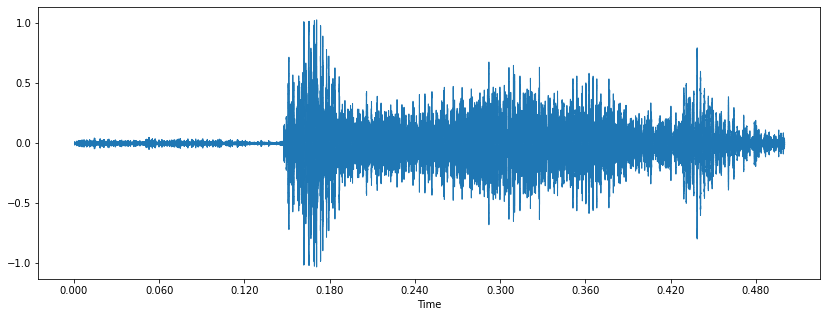

In [4]:
## Sample visualization
plt.figure(figsize=(14,5))
librosa_data,librosa_sample_rate=librosa.load(filename)
librosa.display.waveshow(librosa_data,sr=librosa_sample_rate)
ipd.Audio(filename)

In [5]:
librosa_data.shape

(11025,)

In [6]:
import pandas as pd
Metadata=pd.read_csv("originalimage.csv")
Metadata.head(10)

,participant,filename,imagename,tb_status
0,CODA_TB_0001,1645088710003-recording-1,1645088710003-recording-1.png,0
1,CODA_TB_0001,1645088760390-recording-1,1645088760390-recording-1.png,0
2,CODA_TB_0001,1645088760830-recording-1,1645088760830-recording-1.png,0
3,CODA_TB_0001,1645088710843-recording-1,1645088710843-recording-1.png,0
4,CODA_TB_0001,1645088759950-recording-1,1645088759950-recording-1.png,0
5,CODA_TB_0001,1645088758630-recording-1,1645088758630-recording-1.png,0
6,CODA_TB_0001,1645088758230-recording-1,1645088758230-recording-1.png,0
7,CODA_TB_0001,1645088738844-recording-1,1645088738844-recording-1.png,0
8,CODA_TB_0001,1645088784942-recording-1,1645088784942-recording-1.png,0
9,CODA_TB_0001,1645088784542-recording-1,1645088784542-recording-1.png,0


In [7]:
# Parameters for mel spectrogram computation
n_fft = 2048  # Window size for Fourier transform
hop_length = 512  # Amount of overlap between consecutive frames
n_mels = 128  # Number of mel bands to generate
mel_spec = librosa.feature.melspectrogram(y=librosa_data, sr=librosa_sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

In [8]:
print(len(mel_spec_db))

128


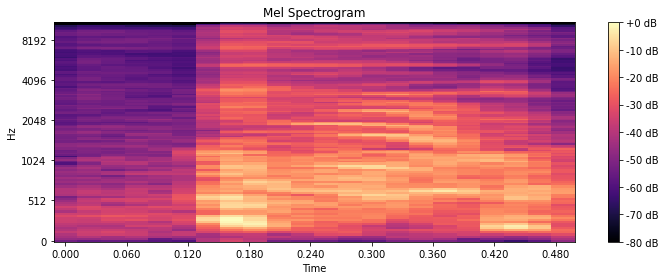

In [9]:
# Display the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=librosa_sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

In [10]:
import numpy as np
import cv2
from PIL import Image

In [12]:
import numpy as np
from tqdm import tqdm
mel_spectrograms=[]
labels=[]

for index_num,row in tqdm(Metadata.iterrows()):
    class_id= row["tb_status"]
    path="target/{}".format(row["imagename"])
    img=cv2.imread(path)
    img=cv2.resize(img,(64,64))
    mel_spectrograms.append(img)
    labels.append(class_id)  

0it [00:00, ?it/s]

27368it [04:51, 94.02it/s] 


In [13]:
# import json
# mel_spectrograms_array=np.array(mel_spectrograms)
# labels_array=np.array(labels)
# x_list = mel_spectrograms_array.tolist()
# y_list = labels_array.tolist()

# data = {
#     "features": x_list,
#     "labels": y_list
# }

# with open('imagefeature.json', 'w') as f:
#     json.dump(data, f)

In [14]:
# Convert the list of Mel spectrograms and labels to NumPy arrays
from tensorflow.keras.utils import to_categorical
mel_spectrograms = np.array(mel_spectrograms)
labels = to_categorical(np.array(labels))

In [15]:
print(mel_spectrograms.shape)
print(labels.shape)

(27368, 64, 64, 3)
(27368, 2)


In [16]:
# split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mel_spectrograms, labels, test_size=0.2,random_state=42)

In [17]:
# X_train = X_train.reshape(21894, 64, 64, 1)
# X_test = X_test.reshape(5474, 64, 64, 1)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21894, 64, 64, 3)
(5474, 64, 64, 3)
(21894, 2)
(5474, 2)


In [19]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.applications.resnet import ResNet50
from keras.optimizers import Adam

In [20]:
base_model = ResNet50(weights=None, include_top=False, input_shape=(64,64,3))

In [21]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [22]:
#model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [23]:
#checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [25]:

model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.125)

Epoch 1/10
201/599 [=========>....................] - ETA: 6:44 - loss: 1.6655 - accuracy: 0.5673

KeyboardInterrupt: 

In [ ]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(test_accuracy)
train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(train_accuracy)

[0.3546663820743561, 0.8472780585289001]
[0.23611734807491302, 0.9003379940986633]


In [ ]:
#model.save('saved_model')